In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from scipy.special import jv

単分散球

In [2]:
def P_intensity(q, scale=1, r=100, SLD_sphere=1e-6, SLD_solvent=6.3e-6, bkgd=0.01):
    q = q * 1e+8
    r = r  * 1e-8
    SLD_sphere = SLD_sphere * 1e+16
    SLD_solvent = SLD_solvent * 1e+16
    delta_rho = SLD_sphere - SLD_solvent
    V = 4 / 3 * np.pi * r**3
    P = (scale / V) * (3 * V * delta_rho * (np.sin(q * r) - q * r * np.cos(q * r)) / (q * r)**3)**2 + bkgd
    return P  # cm^-1

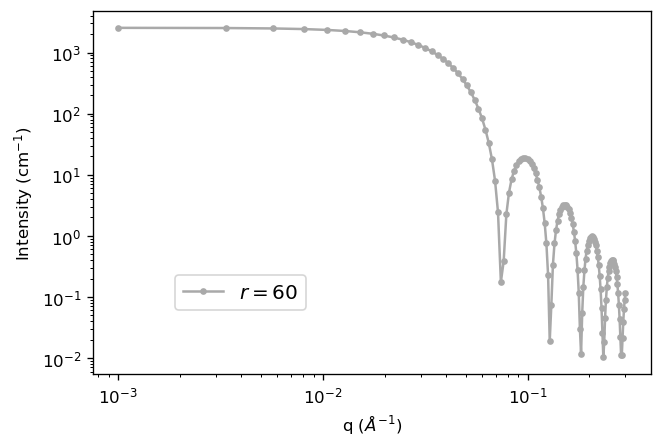

In [3]:
# 半径の大きさがデフォルトのとき
q_min = 0.001  # A^-1
q_max = 0.3    # A^-1

q_array = np.linspace(q_min, q_max, 128)
# print(q_array)

P_array = []
for i in range(len(q_array)):
    P_array.append(P_intensity(q_array[i], r=60))
P_array = np.array(P_array)

fig = plt.figure(dpi=120)
ax = fig.add_subplot()
plt.rcParams["font.size"] = 12

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlabel(r"q ($\AA ^{-1}$)", loc="center")
ax.set_ylabel(r"Intensity (cm$^{-1}$)")

ax.plot(q_array, P_array, marker="o", color="darkgrey", alpha=1., markersize=3, label=r"$r=60$")

ax.legend(bbox_to_anchor=(0.4, 0.3), fontsize=12)

In [4]:
q_min = 0.001  # A^-1
q_max = 0.3    # A^-1

q_array = np.linspace(q_min, q_max, 128)
# print(q_array)

P_array = []
for i in range(len(q_array)):
    P_array.append(P_intensity(q_array[i]))
P_array = np.array(P_array)

In [5]:
P_50_array = []
for i in range(len(q_array)):
    P_50_array.append(P_intensity(q_array[i], r=50))
P_50_array = np.array(P_50_array)

In [6]:
P_150_array = []
for i in range(len(q_array)):
    P_150_array.append(P_intensity(q_array[i], r=150))
P_150_array = np.array(P_150_array)

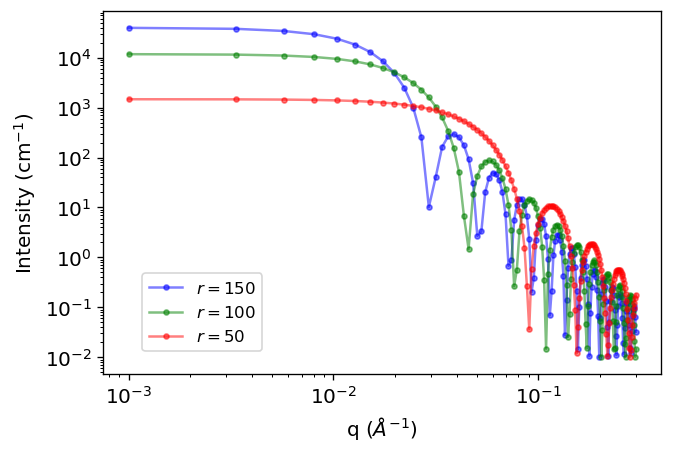

In [7]:
fig = plt.figure(dpi=120)
ax = fig.add_subplot()
plt.rcParams["font.size"] = 12

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlabel(r"q ($\AA ^{-1}$)", loc="center")
ax.set_ylabel(r"Intensity (cm$^{-1}$)")
# ax.set_title("Monodisperse Spheres", loc="center", y=-0.3)

ax.plot(q_array, P_150_array, marker="o", color="blue", alpha=0.5, markersize=3, label=r"$r=150$")
ax.plot(q_array, P_array, marker="o", color="green", alpha=0.5, markersize=3, label=r"$r=100$")
ax.plot(q_array, P_50_array, marker="o", color="red", alpha=0.5, markersize=3, label=r"$r=50$")


ax.legend(bbox_to_anchor=(0.3, 0.3), fontsize=10)

多分散ガウスシェル

In [8]:
# 半径の分布のプロット

def radius_dist(r, mean_radius=60, polydisp=0.2):
    # mean_radius = mean_radius * 1e-8
    sig = mean_radius * polydisp
    func = 1 / (sig * np.sqrt(2 * np.pi)) * np.exp(-1/(2 * sig**2) * (r - mean_radius)**2)
    return func
# plt.plot(r_array, gauss_list)


In [9]:
r_array = np.linspace(0, 150, 256)
gauss_list = []

for r in r_array:
    gauss_list.append(radius_dist(r, polydisp=0.01))

In [10]:
r_array = np.linspace(0, 150, 256)
gauss_list_2 = []

for r in r_array:
    gauss_list_2.append(radius_dist(r, polydisp=0.1))

In [11]:
r_array = np.linspace(0, 150, 256)
gauss_list_3 = []

for r in r_array:
    gauss_list_3.append(radius_dist(r ,polydisp=1.))

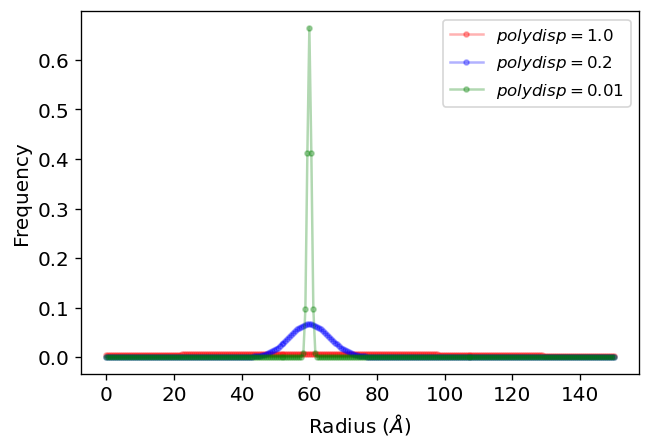

In [12]:
fig = plt.figure(dpi=120)
ax = fig.add_subplot()
plt.rcParams["font.size"] = 12

ax.set_xlabel(r"Radius ($\AA$)", loc="center")
ax.set_ylabel("Frequency")

ax.plot(r_array, gauss_list_3, marker="o", color="red", alpha=0.3, markersize=3, label=r"$polydisp=1.0$")
ax.plot(r_array, gauss_list_2, marker="o", color="blue", alpha=0.3, markersize=3, label=r"$polydisp=0.2$")
ax.plot(r_array, gauss_list, marker="o", color="green", alpha=0.3, markersize=3, label=r"$polydisp=0.01$")

ax.legend(fontsize=10)

強度の計算とプロット

In [13]:
def midpoint_method(func, q, polydisp, r_min=0, r_max=2 * 6 * 1e-7, n=1e+3):
    h = (r_max - r_min) / n
    sum = 0
    for j in range(int(n)+1):
        sum += h * func(r_min + ((2 * j - 1) * h / 2), q, polydisp)
    return sum

In [14]:
def d_intensity(r, q, polydisp, scale=0.01, mean_radius_A=60, SLD_sphere=1e-6, SLD_solvent=3e-6, bkg=0.001, N=1e+16):   # Nは数密度として捉えている．　勝手に決めたもので，使ってはいけない
    # 単位変換
    q = q * 1e+8
    mean_radius = mean_radius_A * 1e-8
    SLD_sphere = SLD_sphere * 1e+16
    SLD_solvent = SLD_solvent * 1e+16
    sig = mean_radius * polydisp
    N0 = 0.01 / ((4 * np.pi / 3) * mean_radius**3 * (1 + 3 * polydisp**16))

    coef = 9 * ((4 * np.pi / 3)**2) * N0 * (SLD_sphere - SLD_solvent)**2 / (sig * np.sqrt(2 * np.pi))   # 取説どおりN0を使用
    d_func = np.exp(-1 / (2 * sig**2) * (r - mean_radius)**2) * (np.sin(q * r) - q * r * np.cos(q * r))**2 / q**6
    return coef * d_func

In [16]:
# この値は下で用いているので重要

N0 = 0.01 / ((4 * np.pi / 3) * (60 * 1e-8)**3 * (1 + 3 * 0.2**16))
print(N0)

1.1052426603386546e+16


In [17]:
q_min = 0.001 #A^-1
q_max = 0.7   #A^-1

polydisp = 0.01

q_num = 128
q_array = np.linspace(q_min, q_max, q_num)
intensity_list = []

for i in tqdm.tqdm(range(q_num)):
    q = q_array[i]
    intensity = midpoint_method(d_intensity, q, polydisp)
    intensity_list.append(intensity)

100%|██████████| 128/128 [00:00<00:00, 247.03it/s]


In [18]:
q_min = 0.001 #A^-1
q_max = 0.7   #A^-1

polydisp = 0.1

q_num = 128
q_array = np.linspace(q_min, q_max, q_num)
intensity_list_2 = []

for i in tqdm.tqdm(range(q_num)):
    q = q_array[i]
    intensity = midpoint_method(d_intensity, q, polydisp) * 10**1
    intensity_list_2.append(intensity)

100%|██████████| 128/128 [00:00<00:00, 258.44it/s]


In [19]:
q_min = 0.001 #A^-1
q_max = 0.7   #A^-1

polydisp = 1.

q_num = 128
q_array = np.linspace(q_min, q_max, q_num)
intensity_list_3 = []

for i in tqdm.tqdm(range(q_num)):
    q = q_array[i]
    intensity = midpoint_method(d_intensity, q, polydisp) * 10**2
    intensity_list_3.append(intensity)

100%|██████████| 128/128 [00:00<00:00, 258.29it/s]


In [20]:
# プロット用にq^-4を整形する
ini_idx = np.where(q_array**(-4) / 10000 < 10**4)[0][0]
print(ini_idx)

2


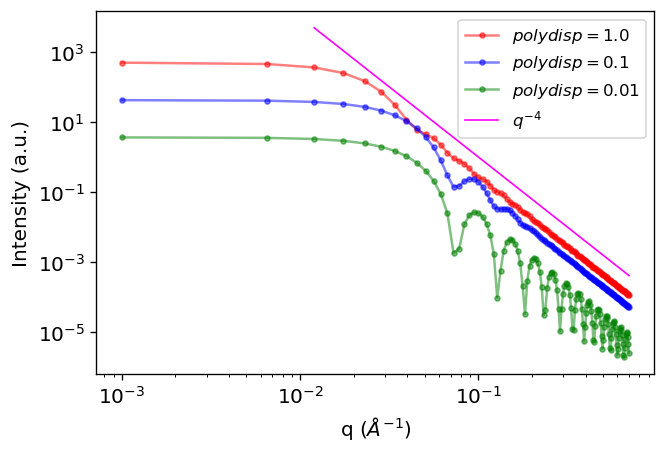

In [21]:
fig = plt.figure(dpi=120)
ax = fig.add_subplot()
plt.rcParams["font.size"] = 12

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlabel(r"q ($\AA ^{-1}$)", loc="center")
ax.set_ylabel(r"Intensity (a.u.)")
# ax.set_title("Polydisperse Spheres", loc="center", y=-0.3)

# ax.plot(q_array, intensity_list_4, marker="o", color="orange", alpha=0.5, markersize=3, label=r"$polydisp=5.0$")
ax.plot(q_array, intensity_list_3, marker="o", color="red", alpha=0.5, markersize=3, label=r"$polydisp=1.0$")
ax.plot(q_array, intensity_list_2, marker="o", color="blue", alpha=0.5, markersize=3, label=r"$polydisp=0.1$")
ax.plot(q_array, intensity_list, marker="o", color="green", alpha=0.5, markersize=3, label=r"$polydisp=0.01$")
ax.plot(q_array[ini_idx : ], (q_array**(-4) / 10000)[ini_idx : ], color="magenta", alpha=1., lw=1 ,label=r"$q^{-4}$")

ax.legend(fontsize=10)

単分散円筒

In [22]:
def dP_cylinders_intensity(a, q, r=20, l=400, scale=1, SLD_cylinder=1e-6, SLD_solvent=6.3e-6):
    q = q * 1e+8
    r = r  * 1e-8
    l = l  * 1e-8
    H = l / 2.
    SLD_cylinder = SLD_cylinder * 1e+16
    SLD_solvent = SLD_solvent * 1e+16
    delta_rho = SLD_cylinder - SLD_solvent
    V = np.pi * r**2 * l
    
    coef = scale * 4 * delta_rho**2 * V
    dP = (np.sin(q * H * np.cos(a)) / (q * H * np.cos(a)))**2 * jv(1, (q * r * np.sin(a)))**2 / (q**2 * r**2 * np.sin(a))
    return dP * coef  # + bkgd # cm^-1

In [23]:
def midpoint_method(func, q, r, l, a_min=0, a_max=np.pi/2, n=1e+3, bkgd=0.01):
    h = (a_max - a_min) / n
    sum = 0
    for j in range(int(n)+1):
        sum += h * func(a_min + ((2 * j - 1) * h / 2), q, r, l)
    return sum + bkgd

In [24]:
q_min = 0.001  # A^-1
q_max = 0.7  # A^-1
data_num = 128

q_array = np.linspace(q_min, q_max, data_num)
cylinders_intensity_list = []

for i in tqdm.tqdm(range(data_num)):
    q = q_array[i]
    cylinders_intensity = midpoint_method(dP_cylinders_intensity, q, r=20, l=400)
    cylinders_intensity_list.append(cylinders_intensity)


100%|██████████| 128/128 [00:00<00:00, 192.32it/s]


In [25]:
q_min = 0.001  # A^-1
q_max = 0.7  # A^-1
data_num = 128

q_array = np.linspace(q_min, q_max, data_num)
cylinders_intensity_list_2 = []

for i in tqdm.tqdm(range(data_num)):
    q = q_array[i]
    cylinders_intensity = midpoint_method(dP_cylinders_intensity, q, r=40, l=400)
    cylinders_intensity_list_2.append(cylinders_intensity)


100%|██████████| 128/128 [00:00<00:00, 185.06it/s]


In [26]:
q_min = 0.001  # A^-1
q_max = 0.7  # A^-1
data_num = 128

q_array = np.linspace(q_min, q_max, data_num)
cylinders_intensity_list_3 = []

for i in tqdm.tqdm(range(data_num)):
    q = q_array[i]
    cylinders_intensity = midpoint_method(dP_cylinders_intensity, q, r=10, l=400)
    cylinders_intensity_list_3.append(cylinders_intensity)

100%|██████████| 128/128 [00:00<00:00, 198.49it/s]


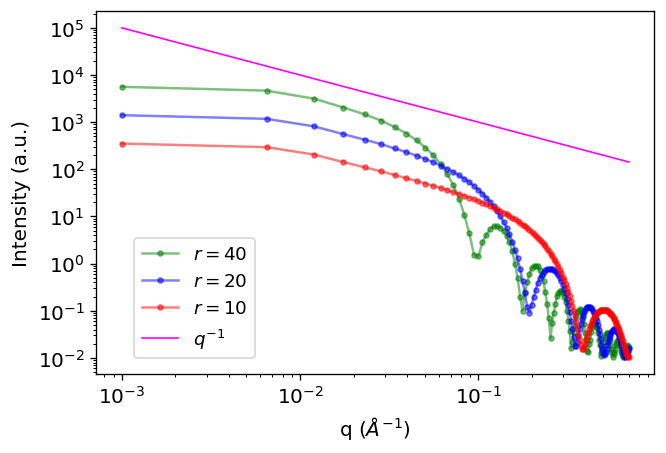

In [27]:
fig = plt.figure(dpi=120)
ax = fig.add_subplot()
plt.rcParams["font.size"] = 12

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlabel(r"q ($\AA ^{-1}$)", loc="center")
ax.set_ylabel(r"Intensity (a.u.)")

ax.plot(q_array, cylinders_intensity_list_2, marker="o", color="green", alpha=0.5, markersize=3, label=r"$r=40$")
ax.plot(q_array, cylinders_intensity_list, marker="o", color="blue", alpha=0.5, markersize=3, label=r"$r=20$")
ax.plot(q_array, cylinders_intensity_list_3, marker="o", color="red", alpha=0.5, markersize=3, label=r"$r=10$")
ax.plot(q_array, q_array**(-1) * 100, color="magenta", alpha=1., lw=1 ,label=r"$q^{-1}$")

ax.legend(bbox_to_anchor=(0.3, 0.4), fontsize=11)

相互作用するガウスシェル系

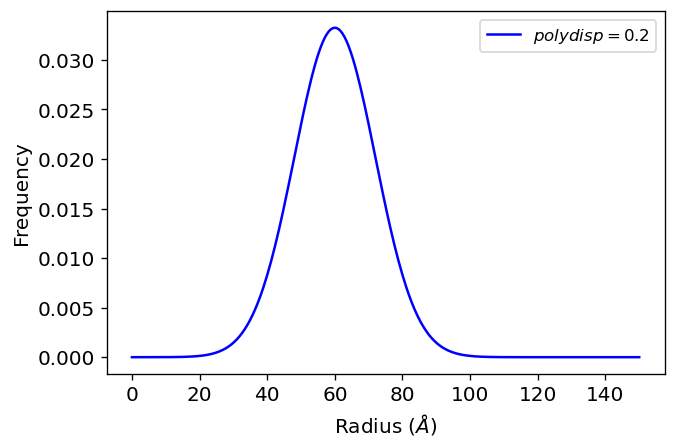

In [28]:
def radius_dist(r, mean_radius=60, polydisp=0.2):
    # mean_radius = mean_radius * 1e-8
    sig = mean_radius * polydisp
    func = 1 / (sig * np.sqrt(2 * np.pi)) * np.exp(-1/(2 * sig**2) * (r - mean_radius)**2)
    return func


r_array = np.linspace(0, 150, 256)
gauss_list_2 = []

for r in r_array:
    gauss_list_2.append(radius_dist(r, polydisp=0.2))


fig = plt.figure(dpi=120)
ax = fig.add_subplot()
plt.rcParams["font.size"] = 12

ax.set_xlabel(r"Radius ($\AA$)", loc="center")
ax.set_ylabel("Frequency")

ax.plot(r_array, gauss_list_2, color="blue", alpha=1., label=r"$polydisp=0.2$")

ax.legend(fontsize=10)


In [29]:
def d_intensity(r, q, polydisp=0.2, scale=0.01, mean_radius=60, SLD_sphere=1e-6, SLD_solvent=3e-6, bkg=0.001, N0=5e+23):   # Nは数密度として捉えている．
    # 単位変換
    q = q * 1e+8
    mean_radius = mean_radius * 1e-8
    SLD_sphere = SLD_sphere * 1e+16
    SLD_solvent = SLD_solvent * 1e+16
    sig = mean_radius * polydisp# * 1e+8
    N0 = scale / ((4 * np.pi / 3) * mean_radius**3 * (1 + 3 * polydisp**16))

    coef = 9 * ((4 * np.pi / 3)**2) * N0 * (SLD_sphere - SLD_solvent)**2 / (sig * np.sqrt(2 * np.pi))
    d_func = np.exp(-1 / (2 * sig**2) * (r - mean_radius)**2) * (np.sin(q * r) - q * r * np.cos(q * r))**2 / q**6
    return coef * d_func

In [31]:
def dS_func(r, q, polydisp=0.2, mean_radius=60, scale=0.01, N0=5e+23):
    q = q * 1e+8
    r = r * 1e-8
    mean_radius = mean_radius * 1e-8
    sig = mean_radius * polydisp# * 1e+8
    N0 = scale / ((4 * np.pi / 3) * mean_radius**3 * (1 + 3 * polydisp**16))
    
    f = 1. / (sig * np.sqrt(2 * np.pi)) * np.exp(-1./(2 * sig**2) * (r - mean_radius)**2)
    S = 4 * np.pi * N0 * r**2 * (f - 1) * np.sin(q * r) / (q * r)
    return S

In [32]:
def midpoint_method(func1, func2, q, polydisp, r_min=0, r_max=2 * 6 * 1e-7, n=1e+3, scale=0.01, bkg=0.001):
    h = (r_max - r_min) / n
    sum1 = 0
    sum2 = 0
    for j in range(int(n)+1):
        sum1 += h * func1(r_min + ((2 * j - 1) * h / 2), q, polydisp)
        sum2 += h * func2(r_min + ((2 * j - 1) * h / 2), q, polydisp)
    return (sum1 * (1 + sum2)) + bkg

In [33]:
q_min = 0.001 #A^-1
q_max = 0.7   #A^-1

polydisp = 0.2

q_num = 128
q_array = np.linspace(q_min, q_max, q_num)
intensity_list = []

for i in tqdm.tqdm(range(q_num)):
    q = q_array[i]
    intensity = midpoint_method(d_intensity, dS_func, q, polydisp)
    intensity_list.append(intensity)

100%|██████████| 128/128 [00:00<00:00, 147.97it/s]


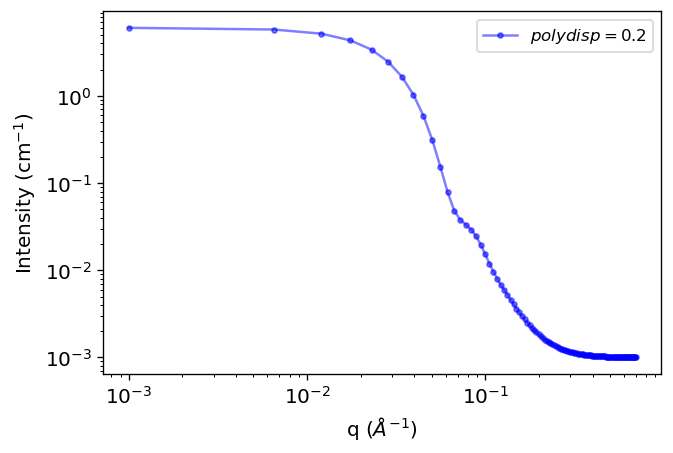

In [34]:
fig = plt.figure(dpi=120)
ax = fig.add_subplot()
plt.rcParams["font.size"] = 12

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlabel(r"q ($\AA ^{-1}$)", loc="center")
ax.set_ylabel(r"Intensity (cm$^{-1}$)")

ax.plot(q_array, intensity_list, marker="o", color="blue", alpha=0.5, markersize=3, label=r"$polydisp=0.2$")

ax.legend(fontsize=10)